In [1]:
import cv2

import numpy as np;
import tifffile
import os
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

In [76]:
# From: https://stackoverflow.com/questions/8076889/how-to-use-opencv-simpleblobdetector

# Get images with segmentation

which_slice = 15
alpha = 0.15

f = lambda tif : (alpha*tif.asarray()[which_slice]).astype('uint8')

dat_foldername = r'..\point_cloud_alignment'

vol0 = os.path.join(dat_foldername, 'img100.tif')
with tifffile.TiffFile(vol0) as tif:
    im1_raw = f(tif)

vol1 = os.path.join(dat_foldername, 'img101.tif')
with tifffile.TiffFile(vol1) as tif:
    im2_raw = f(tif)

## Simplest: find peaks

In [109]:
from skimage.feature import peak_local_max

<IPython.core.display.Javascript object>


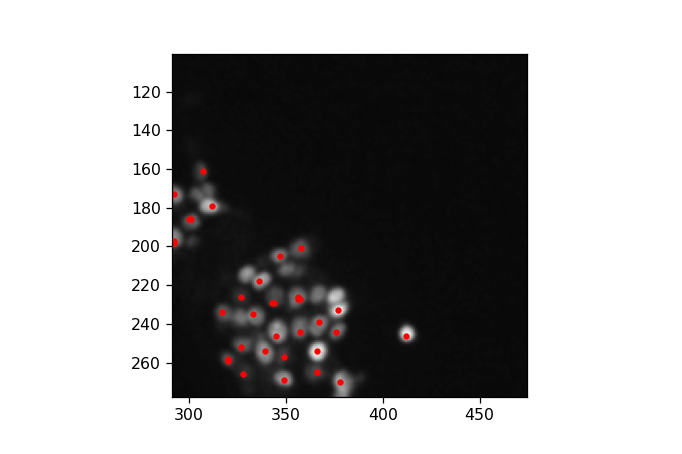

In [138]:
# Background subtraction:
# https://docs.opencv.org/3.3.0/db/d5c/tutorial_py_bg_subtraction.html
# Peak detection:
# https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_peak_local_max.html

#im1 = np.abs(cv2.GaussianBlur(im1_raw,(3,3),0) - np.min(im1_raw))
im1 = cv2.GaussianBlur(im1_raw,(3,3),0)
fgbg = cv2.createBackgroundSubtractorKNN()
fgbg.apply(im1)

%matplotlib notebook
plt.imshow(im1)

thresh = np.mean(im1)+10
coordinates = peak_local_max(im1, min_distance=5, num_peaks=200, threshold_abs=thresh)

In [139]:

plt.imshow(im1, cmap=plt.cm.gray)
plt.plot(coordinates[:, 1], coordinates[:, 0], 'r.')

## Thresholds

In [102]:
# Do some preprocessing
# From: https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_thresholding/py_thresholding.html
# Otsu's thresholding
im1 = cv2.GaussianBlur(im1_raw,(5,5),0)
#ret2,im1 = cv2.threshold(im1,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
im1 = cv2.adaptiveThreshold(im1,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11,2)

# Make neurons dark spts
#im1 = cv2.bitwise_not(im1)

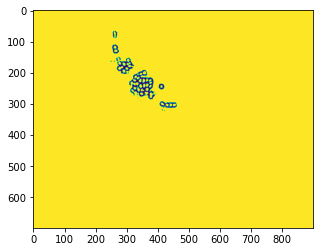

In [103]:
%matplotlib inline
plt.imshow(im1)

## Contours

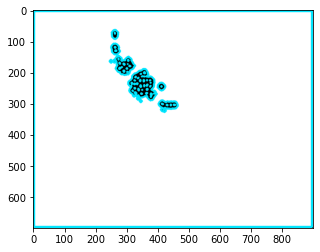

In [107]:
# Just find contours
%matplotlib inline
contours, hierarchy = cv2.findContours(im1, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

im = np.expand_dims(im1, axis=2).repeat(3, axis=2) 
for k, _ in enumerate(contours):
    im = cv2.drawContours(im, contours, k, (0, 230, 255), 6)
plt.imshow(im)

## Blob detector

In [7]:
def detect_blobs(im1_raw):
    im1 = cv2.GaussianBlur(im1_raw,(5,5),0)
    # im1 = cv2.bilateralFilter(im1_raw, 5, 0, 3)

    im1 = cv2.bitwise_not(im1)

    # Setup SimpleBlobDetector parameters.
    params = cv2.SimpleBlobDetector_Params()

    # Change thresholds
    params.minThreshold = 0
    params.maxThreshold = np.max(im1)
    params.thresholdStep = 1

    params.minDistBetweenBlobs = 2

    # Filter by Area.
    params.filterByArea = True
    params.minArea = 5
    params.maxArea = 25

    # Filter by Circularity
    params.filterByCircularity = False
    params.minCircularity = 0.5

    # Filter by Convexity
    params.filterByConvexity = False
    params.minConvexity = 0.2

    # Filter by Inertia
    params.filterByInertia = False
    params.minInertiaRatio = 0.01

    # Create a detector with the parameters
    #detector = cv2.SimpleBlobDetector(params)
    detector = cv2.SimpleBlobDetector_create(params)
    
    # Detect blobs.
    keypoints = detector.detect(im1)
    
    return keypoints, im1

In [201]:
keypoints, _ = detect_blobs(im1_raw)

# Draw detected blobs as red circles.
# cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensures
# the size of the circle corresponds to the size of blob
im_with_keypoints = cv2.drawKeypoints(im1, keypoints, np.array([]), (255,0,0), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Show blobs
#cv2.imshow("Keypoints", im_with_keypoints)

Text(0.5, 1.0, 'Found 22 keypoints')

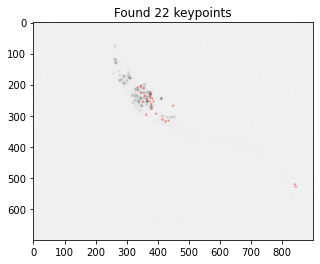

In [202]:
%matplotlib inline
plt.imshow(im_with_keypoints)
plt.title(f"Found {len(keypoints)} keypoints")

## 3d blob detection

In [51]:
from ipywidgets import interact
import open3d as o3d
from DLC_for_WBFM.utils.feature_detection.utils_features import build_feature_tree
from DLC_for_WBFM.utils.feature_detection.visualization_tracks import visualize_cluster_labels

In [8]:
alpha = 0.15

f = lambda dat, which_slice : (alpha*dat[which_slice]).astype('uint8')

dat_foldername = r'..\point_cloud_alignment'

vol0 = os.path.join(dat_foldername, 'img100.tif')


num_slices = 33
with tifffile.TiffFile(vol0) as tif:
    dat = tif.asarray()

## Try to track via ICP on planes

In [47]:
# Build point clouds for each plane

all_keypoints_pcs = []
all_ims_with_kps = []

for i in range(num_slices):
#     print(f"{i} / {num_slices}")
    im1_raw = f(dat, i)
    kp, im1 = detect_blobs(im1_raw)
    # Add to make the format: ZXY
    kp_3d = np.array([np.hstack((i, row.pt)) for row in kp])
    
    pc = o3d.geometry.PointCloud()
    if len(kp_3d) > 0:
        pc.points = o3d.utility.Vector3dVector(kp_3d)

    all_keypoints_pcs.append(pc)

In [264]:
# Build correspondence between each pair of planes

all_icp = []
opt = {'max_correspondence_distance':2.0}

for i in range(0, num_slices-1):
#     print(f"{i} / {num_slices}")
    this_pc = all_keypoints_pcs[i]
    next_pc = all_keypoints_pcs[i+1]
    
    reg = o3d.pipelines.registration.registration_icp(this_pc, next_pc, **opt)
    
    all_icp.append(reg)

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


In [265]:

full_pc = o3d.geometry.PointCloud()
for pc in all_keypoints_pcs:
    full_pc = full_pc + pc

In [266]:
import pandas as pd

In [267]:
# Use registration results to build a combined and colored pointcloud
# pc_ind_to_cluster = []
clust_df = pd.DataFrame(columns=['clust_ind', 'all_ind_local', 'all_ind_global','to_be_finished', 'not_finished'],
                       dtype=object)


def create_new_track(i0, i1, next_clust_ind, clust_df,
                    this_point_cloud_offset,
                    next_point_cloud_offset):
    
    new_track = pd.DataFrame({'clust_ind':next_clust_ind, 
                              'all_ind_local':[[i0,i1]], 
                              'all_ind_global':[[this_point_cloud_offset+i0, i1_global]],
                              'to_be_finished':False, 
                              'not_finished':True})
    clust_df = clust_df.append(new_track, ignore_index=True)
    print(f"Creating new track {next_clust_ind}")
    next_clust_ind = next_clust_ind + 1
    
    return next_clust_ind, clust_df


def extend_track(i1, i1_global, row, i, clust_df):
    row['all_ind_local'].append(i1)
#     print("current local ind", row['all_ind_local'])
    clust_df.at[i,'all_ind_local'] = list(row['all_ind_local'])
    row['all_ind_global'].append(i1_global)
    clust_df.at[i,'all_ind_global'] = list(row['all_ind_global'])
    clust_df.at[i,'to_be_finished'] = False
    
    clust_ind = row['clust_ind']
    tmp = len(row['all_ind_local'])
    print(f"Adding to track {clust_ind} (length {tmp})")
    
    return clust_df

ongoing_tracks = {}
next_clust_ind = 0

this_point_cloud_offset = 0
next_point_cloud_offset = 0

for i_match, reg in enumerate(all_icp):
#     print(f"{i} / {num_slices}")
    # Get transform to global coordinates
    this_pc = all_keypoints_pcs[i_match]
    next_pc = all_keypoints_pcs[i_match+1]
    next_point_cloud_offset = next_point_cloud_offset + len(next_pc.points)
    
    offsets = {'next_point_cloud_offset':next_point_cloud_offset,
               'this_point_cloud_offset':this_point_cloud_offset}
    
    pairs = np.asarray(reg.correspondence_set)
    # Initialize ALL as to-be-finished
    clust_df['to_be_finished'] = True
    
    for i0, i1 in pairs:
#         print(clust_df)
        i1_global = next_point_cloud_offset+i1
        # If no tracks, need special logic
        ind_to_check = clust_df['not_finished']
        if len(ind_to_check)==0:
            next_clust_ind, clust_df = create_new_track(i0, i1, next_clust_ind, clust_df, **offsets)
            continue
        # Add to previous track if possible
        for i, row in clust_df[ind_to_check].iterrows():
#             print(f"pair: {i0}, {i1}, trying cluster: {i}")
            if i0 == row['all_ind_local'][-1]:
                clust_df = extend_track(i1, i1_global, row, i, clust_df)
                break
        else:
            # Create new track
#             if i_match>1:
#                 error
            next_clust_ind, clust_df = create_new_track(i0, i1, next_clust_ind, clust_df, **offsets)
        
    # Finalize tracks that didn't get a new point this loop
    to_finish = clust_df['to_be_finished']
    if len(np.where(to_finish)[0]) > 0:
        print(f"Finished tracks {np.where(to_finish)[0]}")
    clust_df.loc[to_finish,'not_finished'] = False
    
    this_point_cloud_offset = next_point_cloud_offset
        
    
    
#     for i0, i1 in pairs:
#         # Add to previous track if possible
#         for clust_ind, tracklet in ongoing_tracks.items():
#             if i0 in tracklet:
#                 tracklet.append(i1)
#                 finished_tracks.remove(clust_ind)
#                 print(f"Adding to track {clust_ind}")
#                 break
#         else:
#             # Create new track
#             ongoing_tracks[next_clust_ind] = [i0, i1]
#             print(f"Creating new track {next_clust_ind}")
#             next_clust_ind = next_clust_ind + 1
    
#         # Remove finished tracks from the dict
    
        

Creating new track 0
Finished tracks [0]
Creating new track 1
Finished tracks [0]
Adding to track 1 (length 3)
Creating new track 2
Finished tracks [0]
Adding to track 1 (length 4)
Adding to track 2 (length 3)
Creating new track 3
Creating new track 4
Finished tracks [0]
Adding to track 1 (length 5)
Adding to track 4 (length 3)
Adding to track 3 (length 3)
Adding to track 2 (length 4)
Finished tracks [0]
Creating new track 5
Creating new track 6
Creating new track 7
Adding to track 3 (length 4)
Adding to track 4 (length 4)
Adding to track 1 (length 6)
Creating new track 8
Adding to track 2 (length 5)
Adding to track 5 (length 3)
Creating new track 9
Finished tracks [0]
Creating new track 10
Adding to track 10 (length 3)
Creating new track 11
Creating new track 12
Adding to track 2 (length 6)
Creating new track 13
Adding to track 11 (length 3)
Creating new track 14
Creating new track 15
Adding to track 8 (length 3)
Adding to track 12 (length 3)
Adding to track 5 (length 4)
Adding to tra

Creating new track 105
Adding to track 42 (length 11)
Adding to track 69 (length 6)
Adding to track 47 (length 11)
Adding to track 97 (length 3)
Adding to track 84 (length 4)
Adding to track 70 (length 5)
Adding to track 47 (length 12)
Adding to track 61 (length 7)
Finished tracks [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 43 44 45 46 48 49
 50 51 52 54 55 56 57 58 59 60 62 65 66 67 68 71 73 74 75 77 78 79 80 81
 83 85 87 90 92 96]
Adding to track 69 (length 7)
Creating new track 106
Adding to track 84 (length 5)
Creating new track 107
Creating new track 108
Adding to track 105 (length 3)
Adding to track 89 (length 4)
Adding to track 86 (length 4)
Creating new track 109
Creating new track 110
Adding to track 100 (length 3)
Creating new track 111
Adding to track 95 (length 4)
Adding to track 101 (length 3)
Adding to track 103 (length 3)
Adding to track 64 (length 9)
Creating new track 112
Adding to trac

Creating new track 164
Adding to track 136 (length 8)
Creating new track 165
Creating new track 166
Adding to track 89 (length 12)
Adding to track 69 (length 18)
Creating new track 167
Adding to track 133 (length 5)
Creating new track 168
Adding to track 147 (length 4)
Adding to track 133 (length 6)
Creating new track 169
Adding to track 156 (length 4)
Adding to track 157 (length 3)
Adding to track 152 (length 4)
Adding to track 136 (length 9)
Creating new track 170
Adding to track 145 (length 5)
Adding to track 124 (length 6)
Adding to track 129 (length 6)
Adding to track 106 (length 8)
Adding to track 163 (length 3)
Adding to track 131 (length 6)
Adding to track 153 (length 4)
Adding to track 145 (length 6)
Adding to track 95 (length 10)
Creating new track 171
Adding to track 147 (length 5)
Creating new track 172
Adding to track 171 (length 3)
Adding to track 147 (length 6)
Adding to track 133 (length 7)
Adding to track 157 (length 4)
Adding to track 154 (length 3)
Adding to track 13

Creating new track 219
Adding to track 175 (length 9)
Creating new track 220
Creating new track 221
Creating new track 222
Adding to track 152 (length 12)
Adding to track 216 (length 3)
Adding to track 189 (length 6)
Adding to track 132 (length 13)
Creating new track 223
Adding to track 213 (length 3)
Adding to track 216 (length 4)
Creating new track 224
Adding to track 175 (length 10)
Adding to track 213 (length 4)
Adding to track 189 (length 7)
Adding to track 204 (length 5)
Adding to track 182 (length 6)
Adding to track 210 (length 3)
Adding to track 172 (length 13)
Finished tracks [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 10

In [268]:
clust_df

,clust_ind,all_ind_local,all_ind_global,to_be_finished,not_finished
0,0,"[0, 0]","[3, 4]",True,False
1,1,"[0, 0, 0, 0, 0, 23]","[5, 7, 11, 15, 25, 72]",True,False
2,2,"[1, 2, 2, 3, 1, 0, 2, 24, 39]","[8, 13, 17, 28, 50, 83, 85, 145, 204]",True,False
3,3,"[3, 3, 2, 2, 5, 3, 2, 1, 2, 14, 35]","[14, 18, 27, 51, 88, 86, 123, 166, 167, 226, 297]",True,False
4,4,"[1, 1, 1, 0]","[12, 16, 26, 49]",True,False
...,...,...,...,...,...
220,220,"[12, 17]","[1056, 1083]",False,True
221,221,"[22, 21]","[1066, 1087]",False,True
222,222,"[5, 4]","[1049, 1070]",False,True
223,223,"[14, 0]","[1058, 1066]",False,True


In [151]:
new_track = pd.DataFrame({'clust_ind':next_clust_ind, 
                              'all_ind_local':[[i0,i1]], 
                              'all_ind_global':[[this_point_cloud_offset+i0, i1_global]],
                              'to_be_finished':True, 
                              'is_finished':False})
new_track2 = pd.DataFrame({'clust_ind':next_clust_ind, 
                              'all_ind_local':[[i0,i1]], 
                              'all_ind_global':[[this_point_cloud_offset+i0, i1_global]],
                              'to_be_finished':True, 
                              'is_finished':False})

In [154]:
tmp = new_track.append(new_track2)

In [155]:
tmp

,clust_ind,all_ind_local,all_ind_global,to_be_finished,is_finished
0,844,"[23, 7]","[1089, 1073]",True,False
0,844,"[23, 7]","[1089, 1073]",True,False


## Try to track via clustering

In [9]:

all_keypoints = []
all_ims_with_kps = []
    
for i in range(num_slices):
#     print(f"{i} / {num_slices}")
    im1_raw = f(dat, i)
    kp, im1 = detect_blobs(im1_raw)
    # Add to make the format: ZXY
    kp_3d = np.array([np.hstack((i, row.pt)) for row in kp])
    all_keypoints.extend(kp_3d)
    
    im_with_keypoints = cv2.drawKeypoints(im1, kp, np.array([]), (255,0,0), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    all_ims_with_kps.append(im_with_keypoints)

all_keypoints = np.array(all_keypoints)

In [10]:
def my_plot(i): 
    plt.imshow(all_ims_with_kps[i])
    plt.title(f"{i}")

In [11]:
interact(my_plot, i=(0,num_slices-1))

interactive(children=(IntSlider(value=16, description='i', max=32), Output()), _dom_classes=('widget-interact'…

<function __main__.my_plot(i)>

In [12]:

def combine_2d_blobs(all_keypoints, min_z_detections=3):
    """
    Assumes that a real neuron will be detected on more than one plane, and combines them
    """
    
#     all_xyz = all_keypoints[:].pt
    n, point_cloud, tree = build_feature_tree(all_keypoints)
    
    return point_cloud

In [13]:
pc = combine_2d_blobs(all_keypoints)

In [14]:
#o3d.visualization.draw_geometries([pc])

In [30]:
# from sklearn.cluster import SpectralClustering
# opt = {'n_neighbors':2,
#        'n_clusters':150}
# clusterer = SpectralClustering(**opt)

In [32]:
# from sklearn.cluster import AgglomerativeClustering
# opt = {'distance_threshold':2.0,
#        'compute_full_tree':True,
#        'linkage':'single',
#        'n_clusters':None}
# clusterer = AgglomerativeClustering(**opt)

In [38]:
from sklearn.cluster import OPTICS
opt = {'min_samples':2,
       'max_eps':3.0}
clusterer = OPTICS(**opt)

In [39]:
labels = clusterer.fit_predict(pc.points)

In [41]:
visualize_cluster_labels(labels, pc)

point cloud has 307 clusters


## Simple test: dbscan

In [21]:
labels = np.array(pc.cluster_dbscan(eps=1.5, min_points=3))

In [22]:
visualize_cluster_labels(labels, pc)

point cloud has 121 clusters
